In [24]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [25]:
import numpy as np
import pandas as pd

In [26]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [27]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [28]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [29]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [30]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [31]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [32]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

2016-08-23


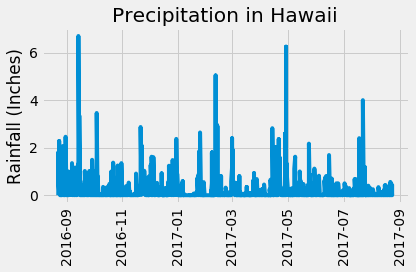

In [33]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
date_prcp_query = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >='2016-08-23', Measurement.date <='2017-08-23').\
order_by(Measurement.date).statement

# Calculate the date 1 year ago from the last data point in the database

one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(one_year_ago)

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column
date_prcp_df = pd.read_sql(date_prcp_query, engine).dropna()
date_prcp_df.head(6)
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

date_prcp_df['date']  = pd.to_datetime(date_prcp_df['date'])
plt.plot(date_prcp_df['date'], date_prcp_df['prcp'])
plt.title("Precipitation in Hawaii")
plt.xlabel('')
plt.ylabel('Rainfall (Inches)')
plt.xticks(rotation='90')
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [34]:
# Use Pandas to calcualte the summary statistics for the precipitation data

date_prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [35]:
# Design a query to show how many stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations available.".format(locations))

There are 9 stations available.


In [36]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
            group_by(Measurement.station).\
            order_by('count DESC').all()
active

C:\Users\ayildirim\AppData\Local\Continuum\anaconda3\lib\site-packages\sqlalchemy\sql\compiler.py:643: SAWarning: Can't resolve label reference 'count DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [37]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 

most_active = session.query(Measurement.station, 
                                    func.count(Measurement.station).\
                                    label('count')).\
                                    group_by(Measurement.station).\
                                    order_by('count DESC').limit(1)[0][0]
most_active
# highest temperature recorded, and average temperature most active station?
temp = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
session.query(*temp).filter(Measurement.station==most_active).all()

[(54.0, 85.0, 71.66378066378067)]

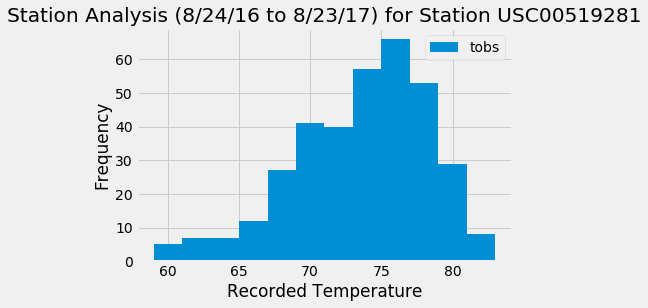

In [38]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(Measurement.tobs).\
                                filter(Measurement.station==most_active).\
                                filter(Measurement.date >= one_year_ago).\
                                order_by(Measurement.date.desc()).all()
temp_obs_df = pd.DataFrame(temp_obs)
temp_obs_df.head()

plt.hist(temp_obs_df['tobs'], bins=12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Frequency")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + most_active)
plt.legend(["tobs"])
plt.show()

![precipitation](Images/station-histogram.png)

In [55]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    c_results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                    filter(Measurement.date >= start_date).\
                    filter(Measurement.date <= end_date).all()
    return c_results
calc_temps('2017-01-01', '2017-12-31')


[(58.0, 74.14387974230493, 87.0)]

In [56]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_results = calc_temps('2017-01-01', '2017-12-31')
trip_results

[(58.0, 74.14387974230493, 87.0)]

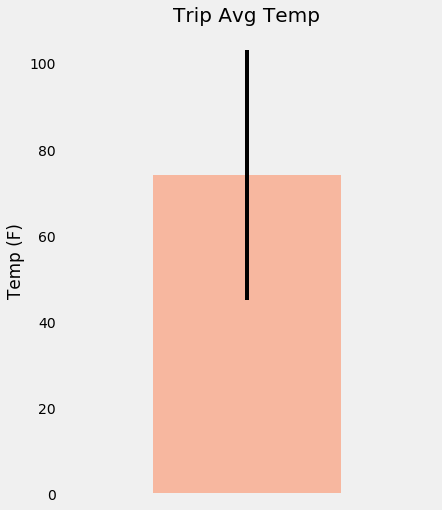

In [58]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.savefig("Output/TripTempSummary.png")
plt.show()



In [42]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [43]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [44]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [45]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [46]:
# Plot the daily normals as an area plot with `stacked=False`
